# Area of Interest 3 (AOI3) Exploratory Data Analysis

## Samuel Levin, samuel.levin@utdallas.edu

### Verify python interpreter (with necessary libraries installed), bulk import

In [1]:
import sys
sys.executable

'C:\\Users\\samle\\AppData\\Local\\ESRI\\conda\\envs\\arcgispro-pyre\\python.exe'

In [2]:
import arcpy
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
import pandas as pd
import seaborn as sns
import scipy

### Extract AOI3 raster from AOI3 vector polygon
### Maintain raster snapping of original flight bands

In [3]:
arcpy.env.workspace = r'<PATH/TO/GDB>'

aoi3_vec = 'AOI3'
flir_stacked = 'FLIR_Stacked_float'

arcpy.env.snapRaster = flir_stacked

fliraoi3 = 'AOI3_FLIR_flt'

aoi3_extract = arcpy.sa.ExtractByMask(arcpy.Raster(flir_stacked), aoi3_vec)
aoi3_extract.save(fliraoi3)

### Cast AOI raster as 3 dimensional NumPy array, assign np.nan to NoData pixels

In [4]:
aoi3 = arcpy.RasterToNumPyArray(fliraoi3, nodata_to_value=np.nan)
aoi3.shape

(5, 802, 814)

### Confirm that all input bands in the AOI extract have the same number of non-np.nan (valid) pixels

In [5]:
for band in range(aoi3.shape[0]):
    nanmask = np.logical_not(np.isnan(aoi3[band]))
    print(aoi3[band][nanmask].shape)

(430310,)
(430310,)
(430310,)
(430310,)
(430310,)


### Build boolean mask of valid data pixels in AOI

In [6]:
np.logical_not(np.isnan(aoi3[0]))

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [7]:
def buildMask(stackedbands):
    individmasks = [np.logical_not(np.isnan(stackedbands[band])) for band in range(stackedbands.shape[0])]
    mask = individmasks[0]
    for im in individmasks:
        mask = np.logical_and(mask, im)
    return mask

In [8]:
aoi3_nanmask = buildMask(aoi3)

(430310,)


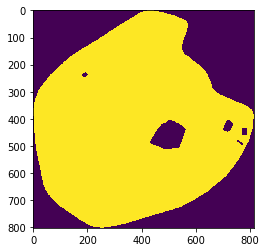

In [9]:
plt.imshow(aoi3_nanmask)
print(aoi3_nanmask[aoi3_nanmask].shape)

### Display all 5 bands of the AOI3 extract

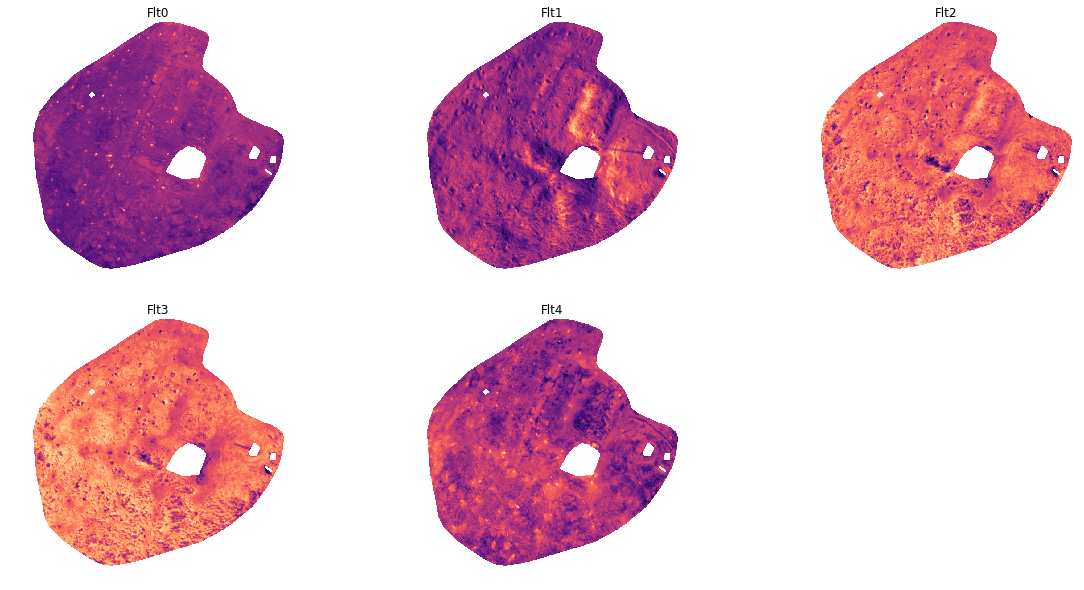

In [10]:
plt.figure(figsize=(20,10))
for band in range(aoi3.shape[0]):
    plot = band+1
    col = 3
    row = math.ceil(aoi3.shape[0]/col)
    
    plt.subplot(row, col, plot)
    plt.title('Flt{}'.format(band))
    plt.axis('off')
    plt.imshow(aoi3[band], cmap='magma')

### Essential summary statistics of each input band in the AOI

In [11]:
def rasterSummary(rast, title): 
    nanmask = np.logical_not(np.isnan(rast))
    
    plt.figure(figsize=(20,7))

    plt.subplot(1,2,1)
    plt.title(title)
    plt.axis('off')
    plt.imshow(rast, cmap='magma')
    plt.colorbar()

    plt.subplot(1,2,2)
    plt.title('{} Histogram'.format(title))
    mini, maxi = np.nanmin(rast), np.nanmax(rast)
    plt.hist(rast[nanmask], bins=50, range=(mini,maxi), color='purple')

    plt.show()
    
    quartiles = np.percentile(rast[nanmask], [25,50,75])
    outstats = [mini, quartiles[0], quartiles[1], quartiles[2], maxi, maxi-mini, 
                quartiles[2]-quartiles[0], np.nanmean(rast), np.nanstd(rast), 
                scipy.stats.skew(rast[nanmask]), scipy.stats.kurtosis(rast[nanmask])]
    statlabel = ['Min.', 'Q1', 'Median', 'Q3', 'Max',
                'Range', 'IQ Range', 'Mean', 'Std. Dev.', 'Skewness', 'Kurtosis']
    outstats = pd.DataFrame({'Value':outstats}, index=statlabel)
    print(outstats)

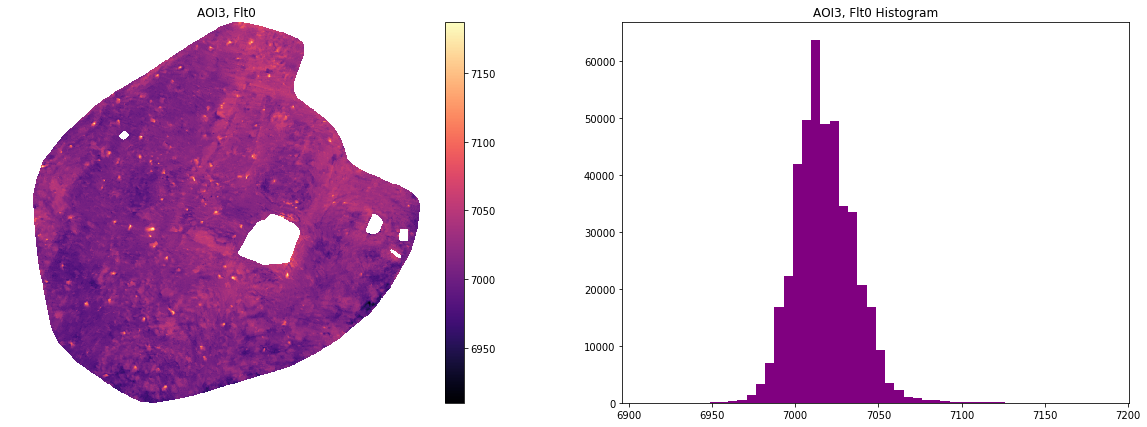

                 Value
Min.       6910.000000
Q1         7006.000000
Median     7016.000000
Q3         7029.000000
Max        7187.000000
Range       277.000000
IQ Range     23.000000
Mean       7017.843750
Std. Dev.    18.066225
Skewness      0.703057
Kurtosis      2.888495


In [12]:
rasterSummary(aoi3[0], 'AOI3, Flt0')

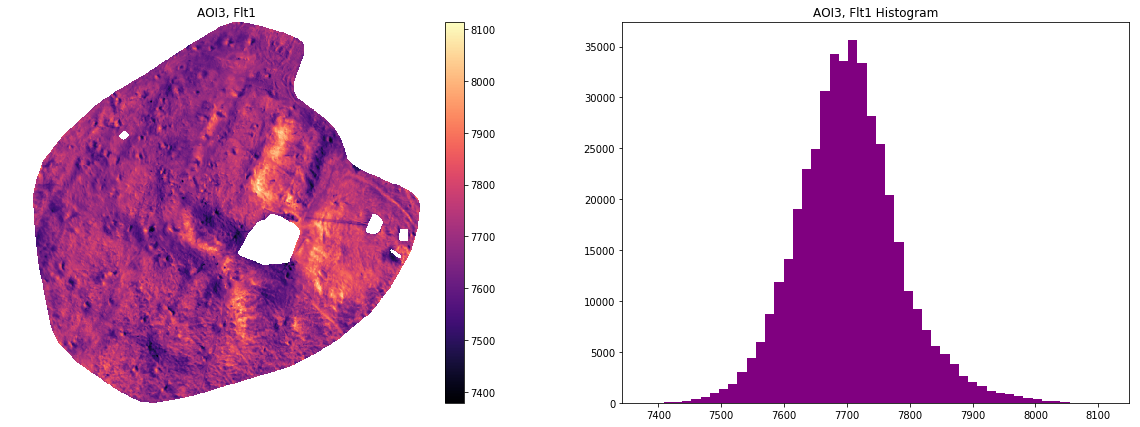

                 Value
Min.       7379.000000
Q1         7651.000000
Median     7700.000000
Q3         7749.000000
Max        8113.000000
Range       734.000000
IQ Range     98.000000
Mean       7702.522461
Std. Dev.    81.349594
Skewness      0.351448
Kurtosis      0.840051


In [13]:
rasterSummary(aoi3[1], 'AOI3, Flt1')

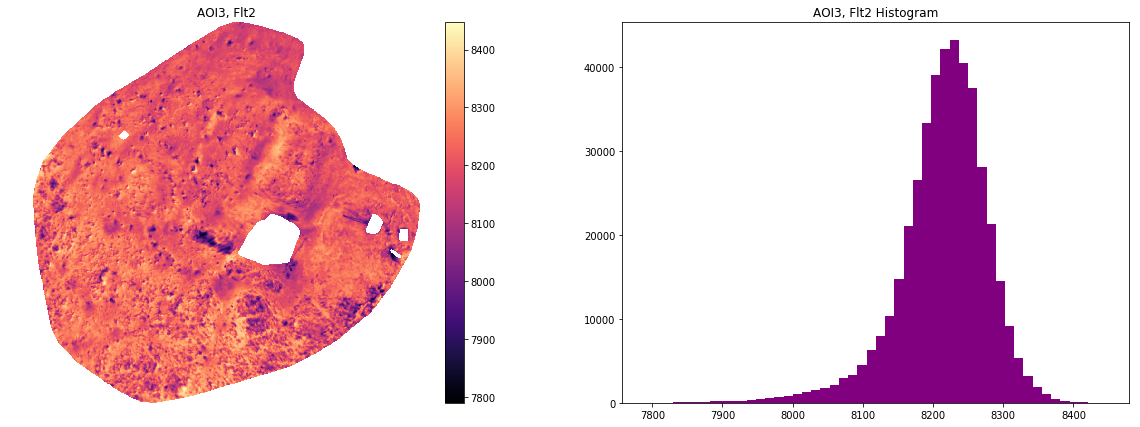

                 Value
Min.       7790.000000
Q1         8184.000000
Median     8221.000000
Q3         8255.000000
Max        8447.000000
Range       657.000000
IQ Range     71.000000
Mean       8214.414062
Std. Dev.    63.275265
Skewness     -1.068060
Kurtosis      2.973649


In [14]:
rasterSummary(aoi3[2], 'AOI3, Flt2')

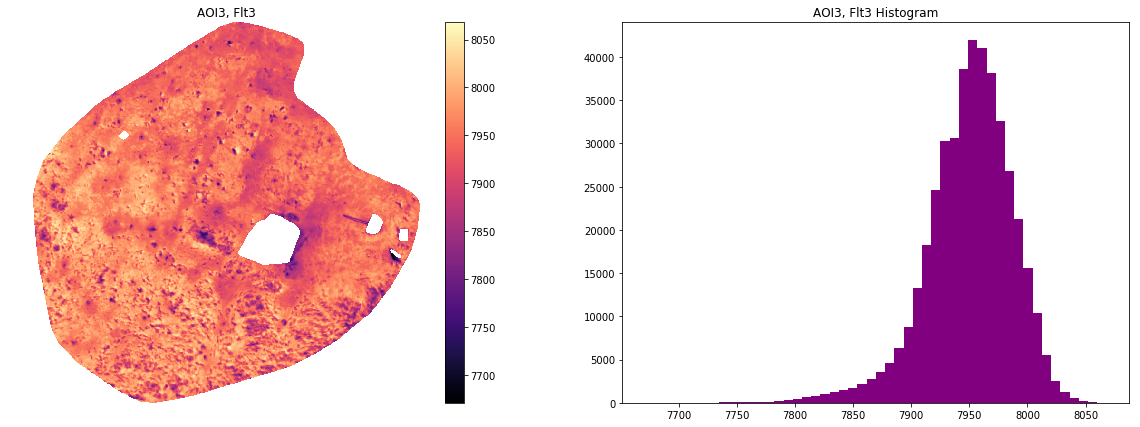

                 Value
Min.       7671.000000
Q1         7930.000000
Median     7953.000000
Q3         7975.000000
Max        8068.000000
Range       397.000000
IQ Range     45.000000
Mean       7949.857910
Std. Dev.    37.214153
Skewness     -0.884066
Kurtosis      2.206848


In [15]:
rasterSummary(aoi3[3], 'AOI3, Flt3')

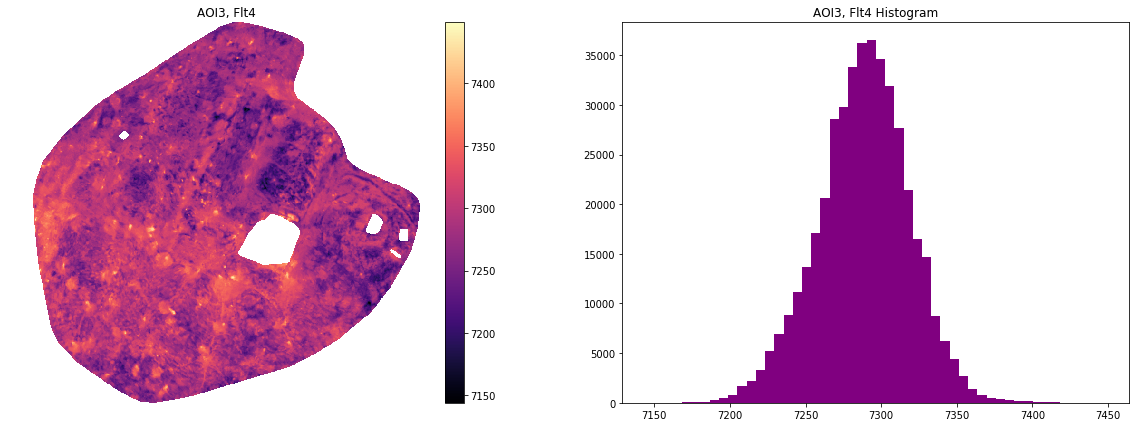

                 Value
Min.       7144.000000
Q1         7269.000000
Median     7290.000000
Q3         7308.000000
Max        7449.000000
Range       305.000000
IQ Range     39.000000
Mean       7288.286621
Std. Dev.    30.293272
Skewness     -0.136684
Kurtosis      0.326753


In [16]:
rasterSummary(aoi3[4], 'AOI3, Flt4')

### Create Pandas DataFrame for further exploration via pairwise plotting of each band

#### Flatten each band into a 1D array and remove null values

In [17]:
aoi3_flat = np.array([aoi3[band].flatten() for band in range(aoi3.shape[0])])

In [18]:
aoi3_flat.shape

(5, 652828)

In [19]:
aoi3_df = pd.DataFrame({'Flt'+str(b):aoi3_flat[b] for b in range(aoi3_flat.shape[0])})

In [20]:
aoi3_df.head()

,Flt0,Flt1,Flt2,Flt3,Flt4
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN


In [21]:
aoi3_df = aoi3_df.dropna().astype(dtype='int32')

In [22]:
aoi3_df.head()

,Flt0,Flt1,Flt2,Flt3,Flt4
422,7041,7762,8207,7967,7233
423,7033,7747,8207,7969,7243
424,7038,7731,8207,7951,7256
1233,7034,7738,8208,7959,7226
1234,7031,7739,8216,7960,7231


In [23]:
aoi3_df.describe()

,Flt0,Flt1,Flt2,Flt3,Flt4
count,430310.000000,430310.000000,430310.000000,430310.000000,430310.000000
mean,7017.843789,7702.521278,8214.415988,7949.857754,7288.287874
std,18.066247,81.349692,63.275340,37.214190,30.293306
min,6910.000000,7379.000000,7790.000000,7671.000000,7144.000000
25%,7006.000000,7651.000000,8184.000000,7930.000000,7269.000000
50%,7016.000000,7700.000000,8221.000000,7953.000000,7290.000000
75%,7029.000000,7749.000000,8255.000000,7975.000000,7308.000000
max,7187.000000,8113.000000,8447.000000,8068.000000,7449.000000


### Pairwise plotting of 5 bands

C:\Users\samle\AppData\Local\ESRI\conda\envs\arcgispro-pyre\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


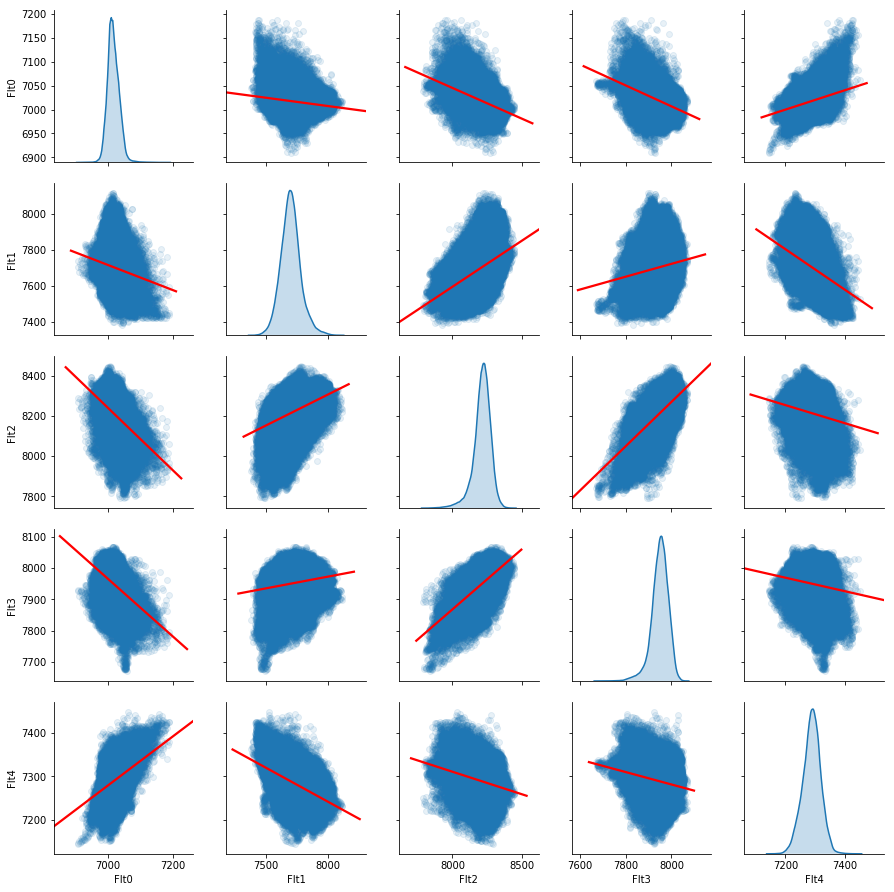

In [24]:
sns.pairplot(aoi3_df, kind='reg', diag_kind="kde", markers='o', plot_kws={'scatter_kws': {'alpha': 0.1}, 
                                                                          'line_kws': {'color': 'red'}})

### Correlatation matrix of 5 input bands

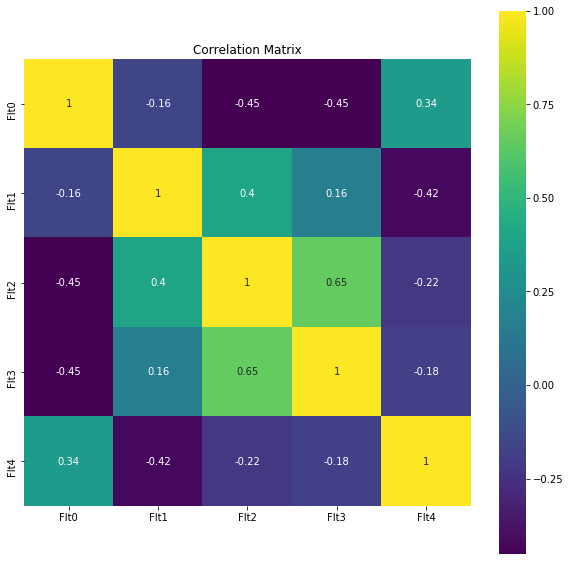

In [25]:
plt.figure(figsize=(10,10))
plt.title('Correlation Matrix')
sns.heatmap(aoi3_df.corr(), annot=True, square=True, cmap='viridis')